In [3]:
import json
from collections import defaultdict
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import pandas as pd
from rliable import plot_utils
plt.rcParams['text.usetex'] = False #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = r'\usepackage{sansmath} \sansmath' #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = ['Helveta Nue'] # Choose a nice font here
sns.set_style("whitegrid")

COLORS = ['#BBCC33', '#77AADD', '#44BB99',
           '#EEDD88', '#EE8866', '#FFAABB',
          '#99DDFF', '#44BB99', '#AAAA00',
          '#DDDDDD']
palette = sns.set_palette(COLORS)

/home/cmu/miniconda3/envs/test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Entropy

In [2]:
entropy = pd.read_csv('data/entropy.csv')

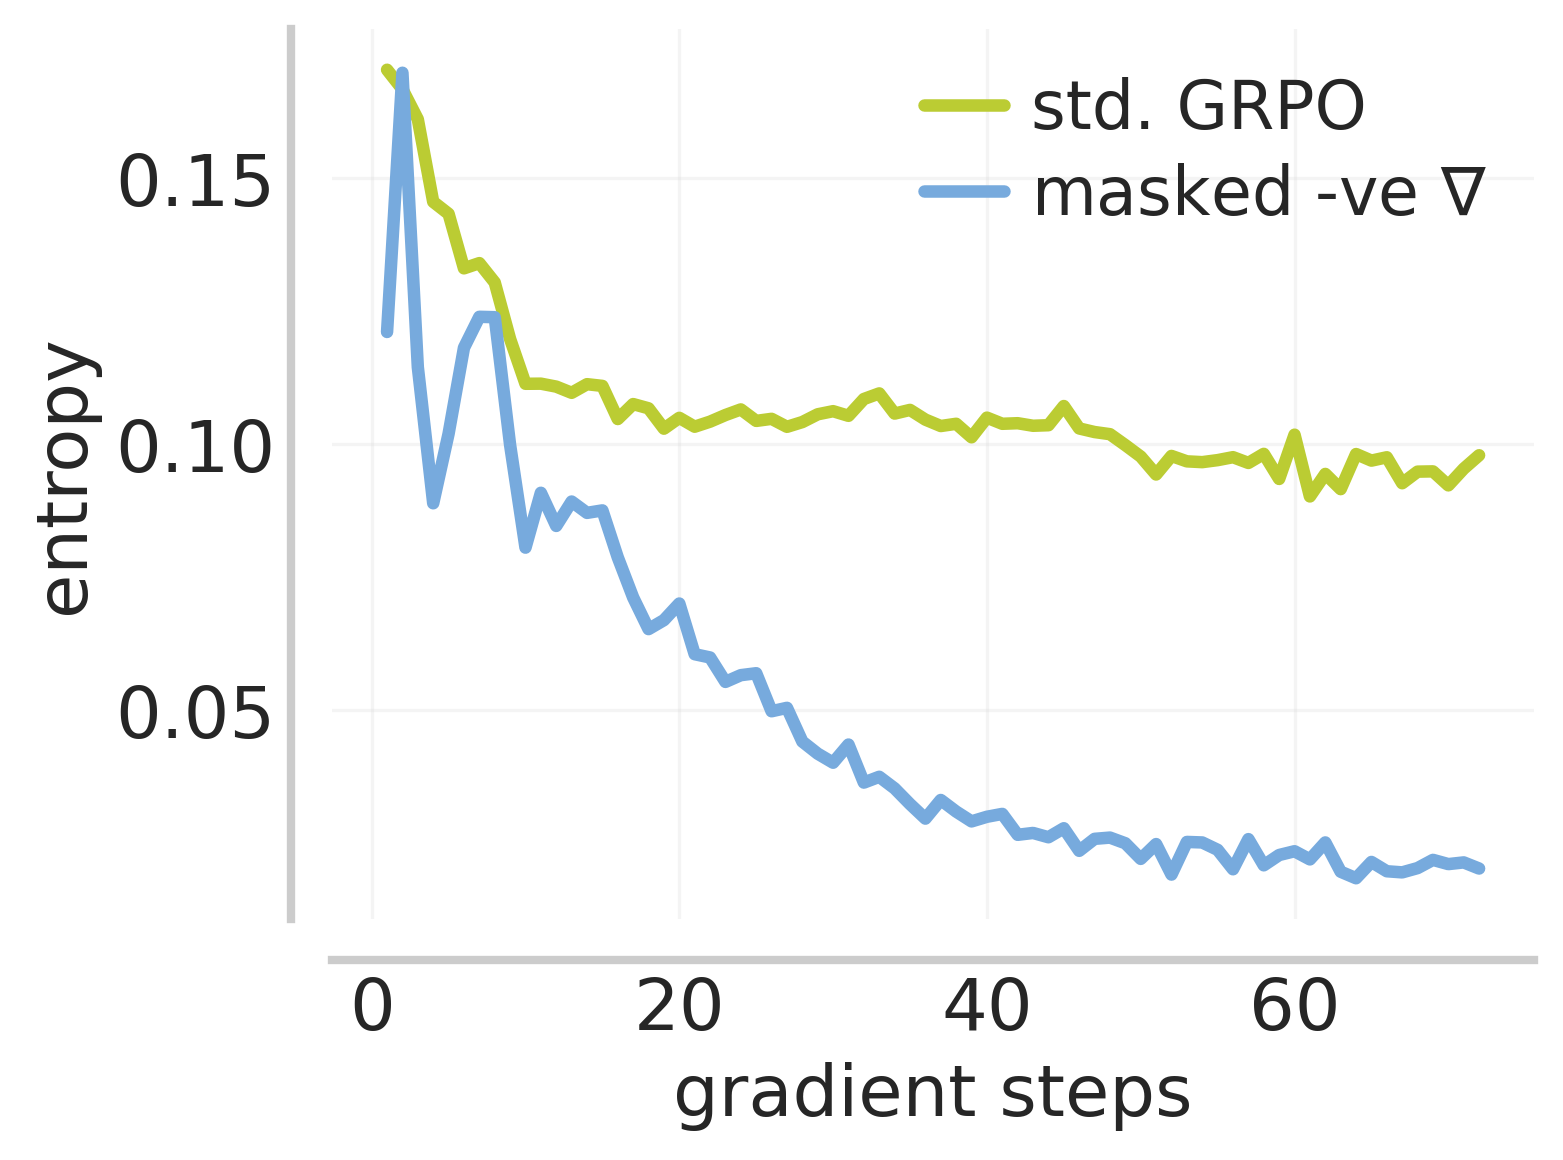

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=300)
fig.set_size_inches(496.0/192*2, 369.6/192*2)

sns.lineplot(data=entropy, x='Step', y='normal - actor/entropy', ax=ax, linewidth=3, markersize=8, color=COLORS[0], label=r'std. GRPO')
sns.lineplot(data=entropy, x='Step', y='positive - actor/entropy', ax=ax, linewidth=3, markersize=8, color=COLORS[1], label=r'masked neg. $\nabla$')

plot_utils._annotate_and_decorate_axis(ax,
                                        xlabel='gradient steps',
                                        ylabel='entropy',
                                        labelsize='xx-large',
                                        ticklabelsize='xx-large',
                                        grid_alpha=0.2,
                                        legend=True)

ax.legend(
        prop={'size': 16},         # Slightly smaller font
        ncol=1,                    # Keep 1 column
        frameon=False,             # No box
        handlelength=1.2,          # Shrink line length
        handletextpad=0.4,         # Shrink space between marker and text
        borderpad=0.2,             # Shrink border padding inside legend box
        labelspacing=0.3,          # Reduce vertical space between entries
        loc="upper right",                # Optional: auto position
        markerscale=0.8,            # Shrink marker size
        # bbox_to_anchor=(-0.1, 1)
    )

plt.savefig("plots/ng_countdown_entropy.pdf", bbox_inches='tight',pad_inches=0)
plt.show()


### Distinct attempts

In [4]:
START_STEP = 0
END_STEP = 90
TEST_FREQ = 15

In [5]:
folder_to_step_to_rollouts = defaultdict(lambda: dict())

for folder in ['normal', 'positive']:
    for step in range(START_STEP, END_STEP + 1, TEST_FREQ):
        rollouts_file = f"/home/cmu/countdown-curriculum/checkpoints/{folder}/{step}_rollouts.json"
        with open(rollouts_file, 'r') as f:
            folder_to_step_to_rollouts[folder][step] = json.load(f)


In [6]:
tokenizer = AutoTokenizer.from_pretrained("d1shs0ap/cognitive-behaviors-Llama-3.2-3B")

In [7]:
def extract_equations(text):
    # Define regex pattern to match equations of the form "a op b = c"
    pattern = re.compile(r'\b\d+\s*[\+\-\*/]\s*\d+\s*=\s*\d+(\.\d+)?\b')
    
    # Go line by line and match
    equations = []
    for line in text.split('\n'):
        match = pattern.search(line)
        if match:
            equations.append(match.group())
    
    return '\n'.join(equations)

In [8]:
TEST1 = """<think>
Let me try to find a way to reach 685.
First, let me look for factors or multiples that might be helpful:
685 = 5 * 137
685 = 17 * 40"""

TEST2 = """Looking at the numbers:
79, 57, 44, 42, 79, 51, 14
I notice we have two 79s, which could be useful.
Let me try working with the two 79s first:
79 + 79 = 158 (too big)
79 - 79 = 0 (too small)
79 * 79 (way too big)
79 / 79 = 1 (too small)"""

TEST3 = """Let me try a different approach:
57 * 14 = 798 (close to 685)
798 - 79 = 719 (too far)"""

TEST4 = """Final attempt:
79 - 42 = 37
37 * 14 = 518
518 + 57 = 575 (getting closer!)"""


ans = extract_equations(TEST2)

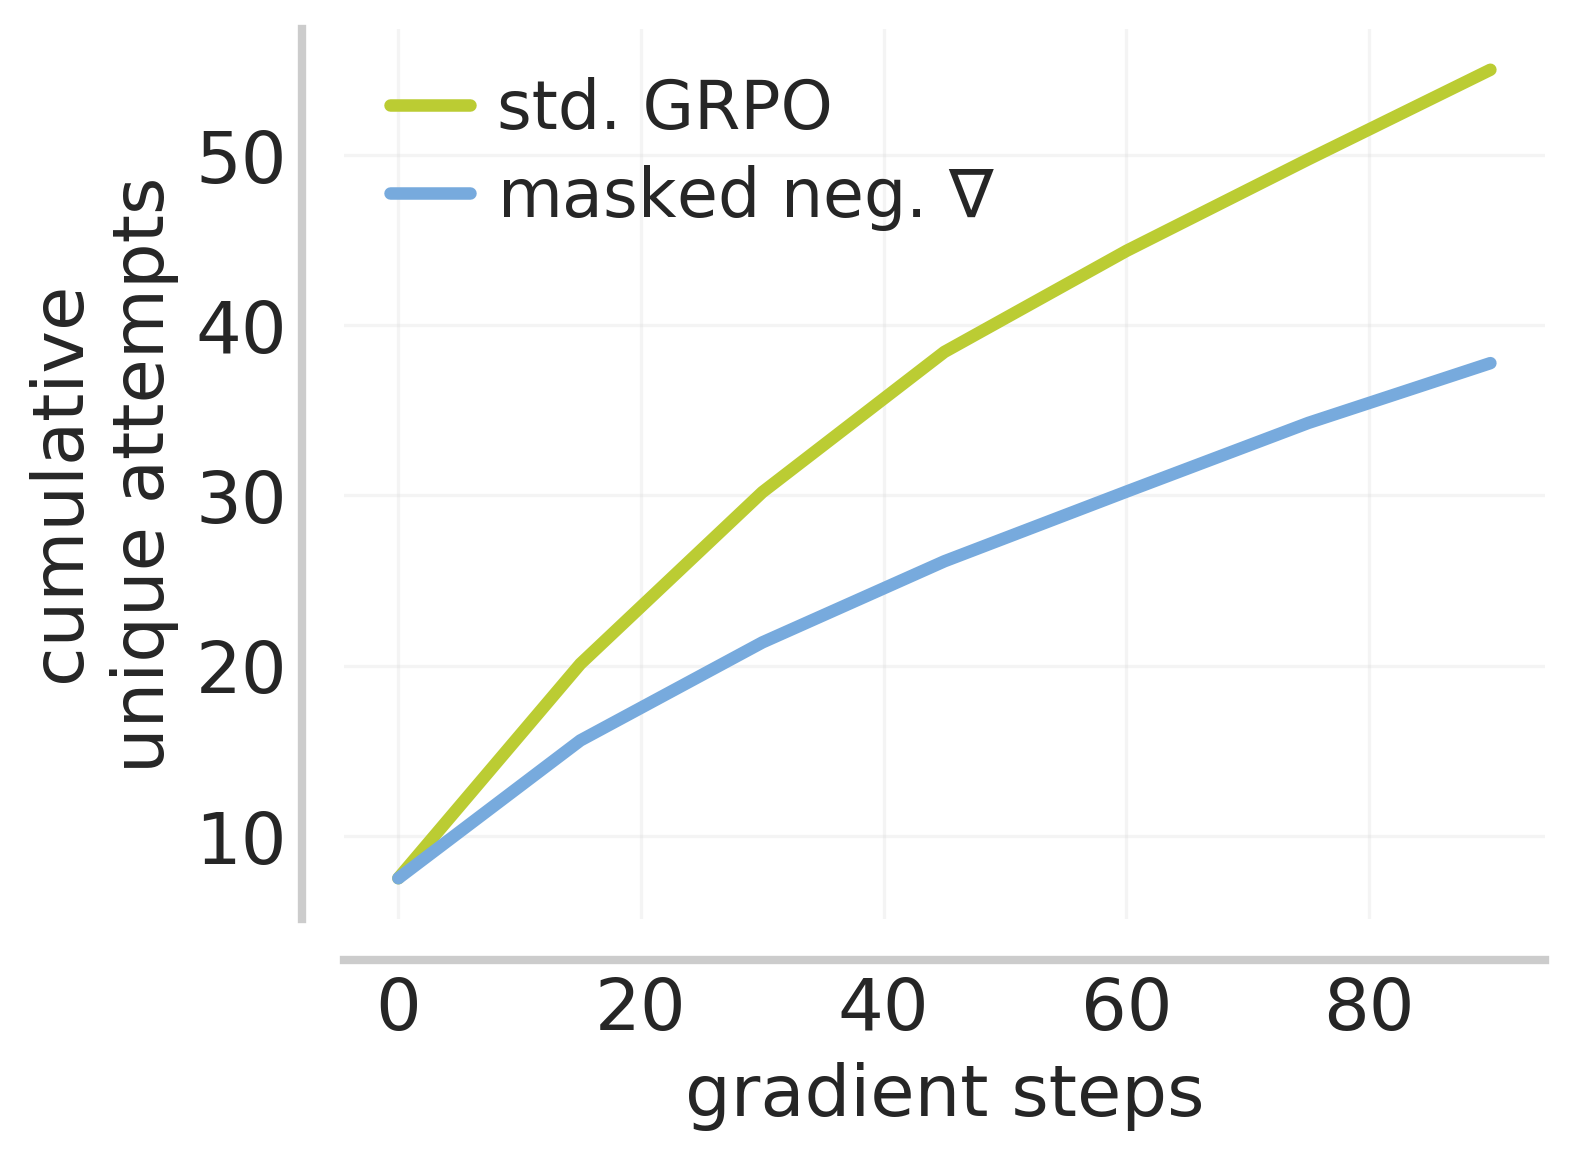

In [9]:
k_fig, k_ax = plt.subplots(nrows=1, ncols=1, dpi=300)
k_fig.set_size_inches(496.0/192*2, 369.6/192*2)

# p_fig, p_ax = plt.subplots(nrows=1, ncols=1)
# p_fig.set_size_inches(496.0/192*2, 369.6/192*2, dpi=300)


for folder in ['normal', 'positive']:
    k = []
    # p = []
    problem_to_cum_attempts = defaultdict(set)
    
    for step in range(START_STEP, END_STEP + 1, TEST_FREQ):
        rollouts = folder_to_step_to_rollouts[folder][step]
        problem_to_cur_attempts = defaultdict(set)
        
        attempts = 0
        cur_attempts = 0
        successes = 0
        total = 0
        for i in range(len(rollouts) // 8):
            if rollouts[i * 8]['ref_score'] != 5:
                continue

            for j in range(8):
                rollout = rollouts[i * 8 + j]

                for attempt in set(rollout['output'].split('\n\n')):
                    problem_to_cum_attempts[i].add(extract_equations(attempt))
                    problem_to_cur_attempts[i].add(extract_equations(attempt))

                successes += rollout['score']
                total += 1
            
            attempts += len(problem_to_cum_attempts[i])
            cur_attempts += len(problem_to_cur_attempts[i])

        k.append(attempts / total)
        # p.append(successes / cur_attempts)

    if folder == 'normal':
        text = r'std. GRPO'
    else:
        text = r'masked neg. $\nabla$'

    sns.lineplot(x=range(START_STEP, END_STEP + 1, TEST_FREQ), y=k, ax=k_ax, linewidth=3, markersize=8, color=COLORS[0] if folder == 'normal' else COLORS[1], label=f'{text}', linestyle='-')
    # sns.lineplot(x=range(START_STEP, END_STEP + 1, TEST_FREQ), y=p, ax=p_ax, linewidth=3, markersize=8, color=COLORS[0] if folder == 'normal' else COLORS[1], label=f'{text}',  linestyle='--')


plt.rcParams["legend.loc"] = "center right"

plot_utils._annotate_and_decorate_axis(k_ax,
                                        xlabel='gradient steps',
                                        ylabel='cumulative \nunique attempts',
                                        labelsize='xx-large',
                                        ticklabelsize='xx-large',
                                        grid_alpha=0.2,
                                        legend=True)

# plot_utils._annotate_and_decorate_axis(p_ax,
#                                         xlabel='gradient steps',
#                                         ylabel='p',
#                                         labelsize='xx-large',
#                                         ticklabelsize='xx-large',
#                                         grid_alpha=0.2,
#                                         legend=True)

k_ax.legend(
        prop={'size': 16},         # Slightly smaller font
        ncol=1,                    # Keep 1 column
        frameon=False,             # No box
        handlelength=1.2,          # Shrink line length
        handletextpad=0.4,         # Shrink space between marker and text
        borderpad=0.2,             # Shrink border padding inside legend box
        labelspacing=0.3,          # Reduce vertical space between entries
        loc="upper left",                # Optional: auto position
        markerscale=0.8,            # Shrink marker size
        # bbox_to_anchor=(-0.1, 1)
    )

# p_ax.legend(
#         prop={'size': 16},         # Slightly smaller font
#         ncol=1,                    # Keep 1 column
#         frameon=False,             # No box
#         handlelength=1.2,          # Shrink line length
#         handletextpad=0.4,         # Shrink space between marker and text
#         borderpad=0.2,             # Shrink border padding inside legend box
#         labelspacing=0.3,          # Reduce vertical space between entries
#         loc="center right",                # Optional: auto position
#         markerscale=0.8,            # Shrink marker size
#         # bbox_to_anchor=(-0.1, 1)
#     )

plt.savefig("plots/ng_countdown_unique_attempts.pdf", bbox_inches='tight',pad_inches=0)

plt.show()

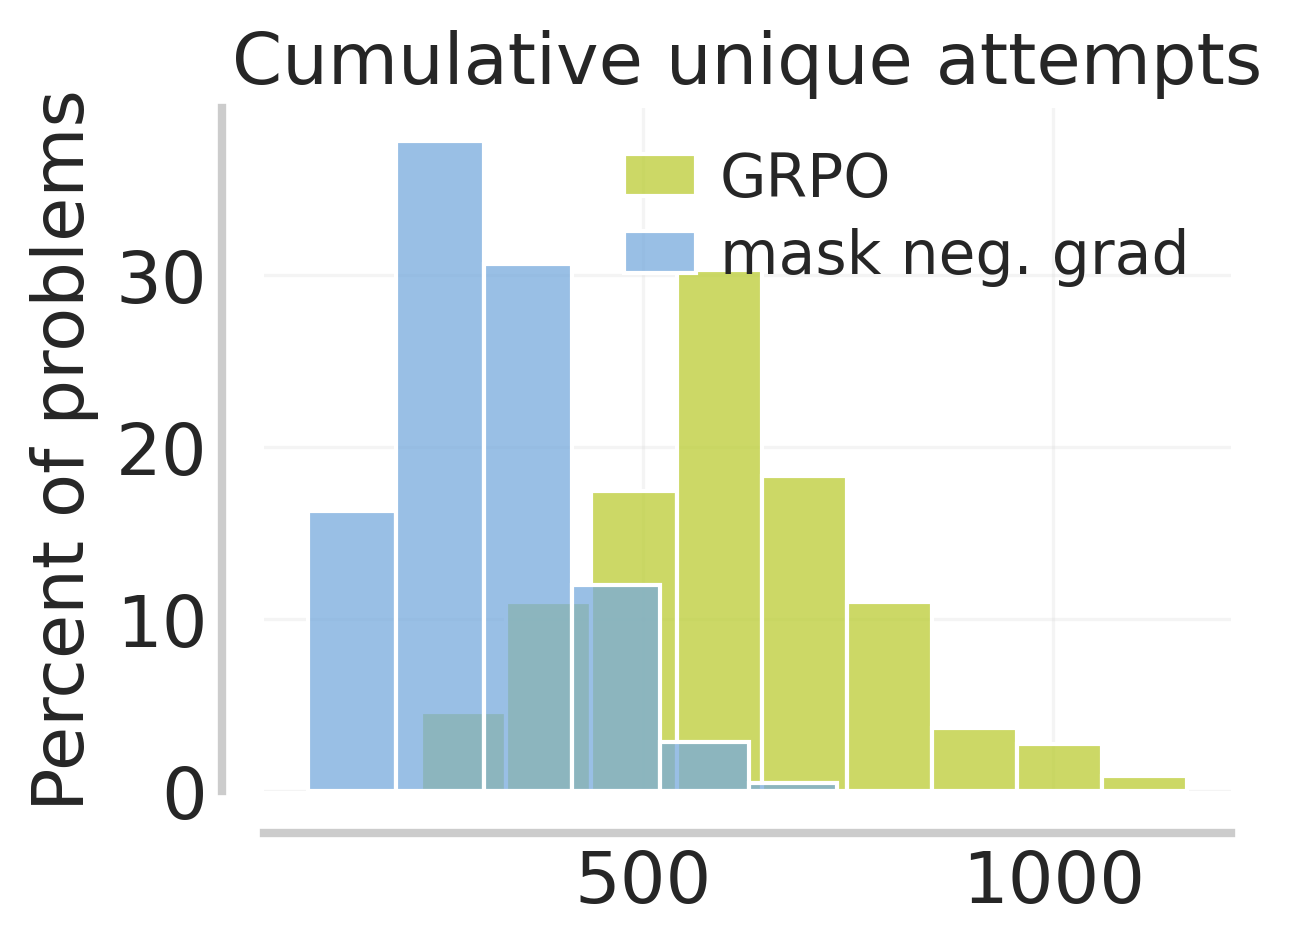

In [29]:
k_fig, k_ax = plt.subplots(nrows=1, ncols=1, dpi=300)
k_fig.set_size_inches(520.0/250*2, 369.6/250*2)


for folder in ['normal', 'positive']:
    problem_to_cum_attempts = defaultdict(set)
    problem_to_incorrects = defaultdict(int)
    
    for step in range(START_STEP, END_STEP + 1, TEST_FREQ):
        rollouts = folder_to_step_to_rollouts[folder][step]
        
        for i in range(len(rollouts) // 8):
            if rollouts[i * 8]['ref_score'] != 5:
                continue

            for j in range(8):
                rollout = rollouts[i * 8 + j]
                if rollout['score'] == 1:
                    continue

                for attempt in set(rollout['output'].split('\n\n')):
                    problem_to_cum_attempts[i].add(extract_equations(attempt))
                
                problem_to_incorrects[i] += 1
            
    if folder == 'normal':
        text = r'GRPO'
    else:
        text = r'mask neg. grad'

    total = len(range(START_STEP, END_STEP + 1, TEST_FREQ)) * 8
    attempts = []
    for problem in problem_to_cum_attempts:
        if problem_to_incorrects[problem] / total < 0.5:
            continue
        attempts.append(len(problem_to_cum_attempts[problem]))
    
    sns.histplot(attempts, color=COLORS[0] if folder == 'normal' else COLORS[1], label=f'{text}', binwidth=100, stat='percent')


plt.rcParams["legend.loc"] = "center right"

plot_utils._annotate_and_decorate_axis(k_ax,
                                        # xlabel='Cumulative unique attempts',
                                        ylabel='Percent of problems',
                                        labelsize='xx-large',
                                        ticklabelsize='xx-large',
                                        grid_alpha=0.2,
                                        legend=True)


k_ax.legend(
        prop={'size': 'x-large'},         # Slightly smaller font
        ncol=1,                    # Keep 1 column
        frameon=False,             # No box
        handlelength=1.2,          # Shrink line length
        handletextpad=0.4,         # Shrink space between marker and text
        borderpad=0.2,             # Shrink border padding inside legend box
        labelspacing=0.3,          # Reduce vertical space between entries
        loc="upper right",                # Optional: auto position
        markerscale=0.8,            # Shrink marker size
        # bbox_to_anchor=(-0.1, 1)
    )

k_ax.set_title('Cumulative unique attempts', fontsize='xx-large')

plt.savefig("plots/ng_countdown_unique_attempts.pdf", bbox_inches='tight')

plt.show()

In [83]:
total

11460

In [95]:
for problem in problem_to_cum_attempts:
    if len(problem_to_cum_attempts[problem]) < 50:
        print(problem)
        print(problem_to_cum_attempts[problem])
        break


108
{'', '93 - 61 = 32\n32 * 10 = 320\n320 + 40 = 360\n360 + 1 = 361\n361 - 28 = 433', '40 + 93 = 133\n133 - 61 = 72\n72 * 10 = 720', '40 + 93 = 133\n133 - 61 = 72\n72 + 1 = 73\n73 + 10 = 83', '10 - 1 = 9\n40 / 10 = 4', '93 * 10 = 930\n93 + 40 = 133\n93 - 40 = 53', '61 / 10 = 6.1\n93 - 40 = 53\n61 / 10 = 114.1\n1 * 1 = 114.1', '93 + 40 = 133\n93 - 40 = 53', '93-61 = 32\n32*10 = 320\n320+40 = 360\n360+73 = 433', '93 - 61 = 32\n40 * 10 = 400\n400 + 32 = 432\n432 + 1 = 433', '93*10 = 930\n40*10 = 400\n93+40 = 133', '40*10 = 400\n400+93 = 493\n400+61 = 461', '93 - 61 = 32\n32 * 10 = 320\n320 + 40 = 360\n360 + 1 = 361', '40 * 10 = 400\n93 + 61 = 154\n154 - 71 = 83\n400 + 33 = 433', '61 + 93 = 154\n154 - 40 = 114\n114 + 10 = 124', '40*10 = 400\n400+61 = 461\n461-93 = 368\n368+1 = 369', '93 + 61 = 154\n154 - 40 = 114\n114 + 10 = 124\n124 - 61 = 63', '93 - 40 = 53\n53 + 10 = 63\n63 + 1 = 64', '93 - 61 = 32\n40 * 10 = 400\n400 + 33 = 433', '61 * 10 = 610\n610 - 93 = 517\n517 - 40 = 477\n477 + 1

In [77]:
rollouts[18 * 8 + 7]

{'input': 'A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer.\nUser: Using the numbers [81, 88, 70, 29, 13], create an equation that equals 47. You can use basic arithmetic operations (+, -, *, /) and each number can only be used once. Show your work in <think> </think> tags. And return the final answer in <answer> </answer> tags, for example <answer> (1 + 2) / 3 </answer>.\nAssistant: Let me solve this step by step.\n',
 'output': "<think>\nLet me analyze this step by step:\n\n1. First, let's try to get close to 47 by looking at the numbers:\n- 88 is much larger than 47, so we'll need to subtract\n- 81 is also larger than 47\n- 70 is larger than 47\n- 29 and 13 are smaller than 47\n\n2. Let's try working with 88 since it's the largest:\n88 - 81 = 7 (too small)\n88 - 70 = 18 (too small)\n88 - 29 = 59 (getting closer)\n88 - 13 = 75